In [1]:
#import relevant packages
%matplotlib inline
import numpy as np
import pandas as pd #to pull data from excel files
from scipy import stats
import matplotlib.pyplot as plt #plotting 

In [2]:
def AMA_parser_1(file_name, skiprows, ylabel, discard_chunk, discard_misc, blanks, data_labels, plot_title, 
                 time_int = 0.25, output = "output_file.png", empties = True, time_point = False, 
                 subtraction = True, averaging = False, growth_curves = False, lineplots = False, boxplots = True, save = False):
  
    #read in data with proper encoding, skipping metadata in first two and last four rows
    df = pd.read_table(file_name, skiprows=skiprows, skipfooter=4, engine = 'python')
    
    #discard wells we don't care about, as specified in list of strings "discard"
    #also automatically discard pre-specified empty outer wells unless empties == False
    
    df = df.dropna(axis = 1)
    
    if empties == True:
        
        junk_and_water_wells = ["Temperature(¡C)", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", 
               "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "B1", "C1", "D1", "E1", 
               "F1", "G1", "B12", "C12", "D12", "E12", "F12", "G12"]
        
        df = df.drop(junk_and_water_wells, axis = 1)
        df = df.drop(df.loc[:,discard_chunk[0]:discard_chunk[1]], axis = 1)  
        df = df.drop(discard_misc, axis = 1)  
        
    #Rename Time column and blank columns - blanks specified by user
    df = df.rename(columns = {blanks[0]:"Blank 1", blanks[1]: "Blank 2", blanks[2]:"Blank 3"})
     
    #Take average of 3 blanks and subtract from all data
    if subtraction == True:
        
        blank = (df["Blank 1"] + df["Blank 2"] + df["Blank 3"])/3
                
        d2 = []

        for i in range(len(df.columns)):
    
            if i+1 < len(df.columns):
                d = df.iloc[:,i+1] - blank
                d2.append(d)

        df = pd.DataFrame(d2).T
        
        
    #average triplicate data
    if averaging == True:
        
        aves = []
        
        for i in range(len(data_labels)):
            ave = (df.iloc[:,3*i] + df.iloc[:,3*i+1] + df.iloc[:,3*i+2])/3
            aves.append(ave)
        
        df = pd.DataFrame(aves, index = data_labels).T
        
    #Overwrite time as float in hours
    time = []
    
    for i in range(len(df)): 
        if i == 0:
            time.append(i)
        else:  
            time.append(time[i-1] + time_int)
        
    df["Time (hours)"] = time
    
    #optional plotting of triplicate-averaged growth curves when growth_curves == True
    if growth_curves == True:
        for i in range(len(df.columns)):
                df.plot.scatter(x = "Time (hours)", y = df.columns[i])
    
    #default boxplots of all data (leaves out blank)    
    if boxplots == True:
        
        aves = []
        
        t = df.index[df["Time (hours)"] == time_point].values
        
        WT = (df.loc[t, 3].values + df.loc[t, 4].values + df.loc[t, 5].values)/3
        
        for i in range(len(data_labels)):
            ave = [100*df.loc[t, 3*i+3].values/WT, 
                    100*df.loc[t, 3*i+4].values/WT, 
                    100*df.loc[t, 3*i+5].values/WT]
            flattened = np.hstack(ave).tolist()
            aves.append(flattened)
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1) 
        ax.boxplot(aves, labels = data_labels)
        plt.ylabel(ylabel)
        plt.xticks(rotation = 60)
        plt.ylim(0, 125)
        plt.title(plot_title)
        plt.tight_layout()
        
    if lineplots == True:
        
        aves = []
        
        t = df.index[df["Time (hours)"] == time_point].values
        
        WT = (df.loc[t, 3].values + df.loc[t, 4].values + df.loc[t, 5].values)/3
        
        for i in range(len(data_labels)):
            ave = [100*df.loc[t, 3*i+3].values/WT, 
                    100*df.loc[t, 3*i+4].values/WT, 
                    100*df.loc[t, 3*i+5].values/WT]
            flattened = np.hstack(ave).tolist()
            aves.append(flattened)
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1) 
        ax.plot(aves, )
        plt.ylabel(ylabel)
        plt.ylim(0, 125)
        plt.title(plot_title)
        plt.tight_layout()
        
    if save == True:
        plt.savefig(output)

[Ttest_indResult(statistic=-1.8696967919509981, pvalue=0.13487840629151357), Ttest_indResult(statistic=-2.5882005847321237, pvalue=0.060799134645543422), Ttest_indResult(statistic=-3.3538182384579911, pvalue=0.028467702304639044), Ttest_indResult(statistic=-3.4077414269121338, pvalue=0.027083605672764039), Ttest_indResult(statistic=1.2571955929560474, pvalue=0.27708271239717946), Ttest_indResult(statistic=6.7947003406707331, pvalue=0.0024503188173145576), Ttest_indResult(statistic=9.1100419602954545, pvalue=0.00080531316378050272)]


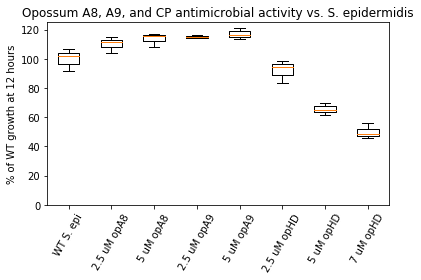

In [126]:
file_name = "170507_AMA_opossums_and_chicken_edited.txt"

#range of wells not used - removes all wells in between the two wells specified (inclusive)
discard_chunk = [""]

#additional wells to discard that don't fall within discard_chunk
discard_misc = [""]

#labels corresponding to wells containing blank media
blanks = ["B2", "C2", "D2"]

#desired data labels - must include blank 
data_labels = ["WT S. epi", "2.5 uM opA8", "5 uM opA8", "2.5 uM opA9", "5 uM opA9", "2.5 uM opHD", 
              "5 uM opHD", "7 uM opHD"]

#give output file a name
output = "170525_opossums_dose_curve_plot.png"

#give boxplot a title 
plot_title = "Opossum A8, A9, and CP antimicrobial activity vs. S. epidermidis"

#ylabel title
ylabel = "% of WT growth at 12 hours"

op_data = AMA_parser_1(file_name, 0, ylabel, discard_chunk, discard_misc, blanks, data_labels, output = output, 
                       plot_title = plot_title, time_point = 12, empties = False, boxplots = False, lineplots = True, 
                       save = False)

op_data

Ttest_indResult(statistic=2.4748071016353568, pvalue=0.089681438409387734)

In [87]:
data_labels = ["Blank", "WT S. epi", "2.5 uM opA8", "5 uM opA8", "2.5 uM opA9", "5 uM opA9", "7 uM opA9", "2.5 uM opHD", 
              "5 uM opHD", "7 uM opHD", "2.5 uM chMRP126", "5 uM chMRP126"]

plot_title = "plot_title"

op_data_2 = AMA_parser_1(file_name, 0, ylabel, discard_chunk, discard_misc, blanks, data_labels, output = output, 
                         plot_title = plot_title, time_point = 12, empties = False, save = False, 
                         boxplots = False, averaging = True, growth_curves = True)

op_data_2

IndexError: single positional indexer is out-of-bounds

In [3]:
def AMA_parser(file_name, skiprows, ylabel, discard_chunk, discard_misc, blanks, data_labels, plot_title, time_int = 0.25, output = "output_file.png", 
               empties = True, time_point = False, subtraction = True, averaging = False, 
               growth_curves = False, boxplots = True, save = False):
  
    #read in data with proper encoding, skipping metadata in first two and last four rows
    df = pd.read_table(file_name, encoding = "utf-16", skiprows=skiprows, skipfooter=4, engine = 'python')
    
    #discard wells we don't care about, as specified in list of strings "discard"
    #also automatically discard pre-specified empty outer wells unless empties == False
    
    if empties == True:
        
        junk_and_water_wells = ["Temperature(¡C)", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", 
               "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "B1", "C1", "D1", "E1", 
               "F1", "G1", "B12", "C12", "D12", "E12", "F12", "G12"]
        
        df = df.drop(junk_and_water_wells, axis = 1)
        df = df.drop(df.loc[:,discard_chunk[0]:discard_chunk[1]], axis = 1)  
        df = df.drop(discard_misc, axis = 1)  
        
    #Rename Time column and blank columns - blanks specified by user
    df = df.rename(columns = {blanks[0]:"Blank 1", blanks[1]: "Blank 2", blanks[2]:"Blank 3"})
     
    #Take average of 3 blanks and subtract from all data
    if subtraction == True:
        
        blank = (df["Blank 1"] + df["Blank 2"] + df["Blank 3"])/3
                
        d2 = []

        for i in range(len(df.columns)):
    
            if i+1 < len(df.columns):
                d = df.iloc[:,i+1] - blank
                d2.append(d)

        df = pd.DataFrame(d2).T
        
        
    #average triplicate data
    if averaging == True:
        
        aves = []
        
        for i in range(len(data_labels)):
            ave = (df.iloc[:,3*i] + df.iloc[:,3*i+1] + df.iloc[:,3*i+2])/3
            aves.append(ave)
        
        df = pd.DataFrame(aves, index = data_labels).T
        
    #Overwrite time as float in hours
    time = []
    
    for i in range(len(df)): 
        if i == 0:
            time.append(i)
        else:  
            time.append(time[i-1] + time_int)
        
    df["Time (hours)"] = time
    
    #optional plotting of triplicate-averaged growth curves when growth_curves == True
    if growth_curves == True:
        for i in range(len(df.columns)):
                df.plot.scatter(x = "Time (hours)", y = df.columns[i])
                
    #default boxplots of all data (leaves out blank)
    if boxplots == True:
        
        aves = []
        
        t = df.index[df["Time (hours)"] == time_point].values
        
        WT = (df.loc[t, 3].values + df.loc[t, 4].values + df.loc[t, 5].values)/3
        
        for i in range(len(data_labels)):
            ave = [100*df.loc[t, 3*i+3].values/WT, 
                    100*df.loc[t, 3*i+4].values/WT, 
                    100*df.loc[t, 3*i+5].values/WT]
            flattened = np.hstack(ave).tolist()
            aves.append(flattened)
        
         #t_test: 
        pvalues = []
        
        for i in range(len(aves)):
            if i > 0:
                p = stats.ttest_ind(aves[0], aves[i])
                pvalues.append(p)
                
        print(pvalues)
        
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1) 
        ax.boxplot(aves, labels = data_labels)
        plt.ylabel(ylabel)
        plt.xticks(rotation = 60)
        plt.ylim(0, 125)
        plt.title(plot_title)
        plt.tight_layout()
        
    if save == True:
        plt.savefig(output)

[Ttest_indResult(statistic=2.066549741047162, pvalue=0.10765018580535278), Ttest_indResult(statistic=2.9426507320000814, pvalue=0.042277386724436081), Ttest_indResult(statistic=2.3649461895020218, pvalue=0.077245160719944417), Ttest_indResult(statistic=1.909332279491937, pvalue=0.12884502292831201)]


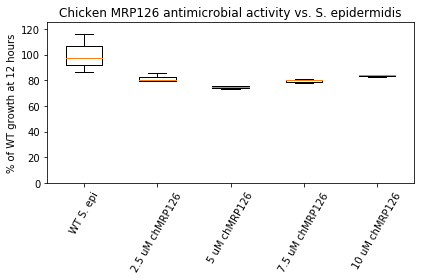

In [124]:
#User inputs
#############################################################################################

file_name = "170517_AMA_chMRP126_dose_curve.txt"

#range of wells not used - removes all wells in between the two wells specified (inclusive)
discard_chunk = ["C11","G11"]

#additional wells to discard that don't fall within discard_chunk
discard_misc = ["B11"]

#labels corresponding to wells containing blank media
blanks = ["B2", "B3", "B4"]

#desired data labels - must include blank 
data_labels = ["WT S. epi", "2.5 uM chMRP126", "5 uM chMRP126", "7.5 uM chMRP126", "10 uM chMRP126"]

#give output file a name
output = "170524_chMRP126_dose_curve_plot.png"

#give boxplot a title
plot_title = "Chicken MRP126 antimicrobial activity vs. S. epidermidis"

ylabel = "% of WT growth at 12 hours"

ch_data = AMA_parser(file_name, 2, ylabel, discard_chunk, discard_misc, blanks, data_labels, plot_title = plot_title, 
                     output = output, time_point = 12, save = True)

ch_data

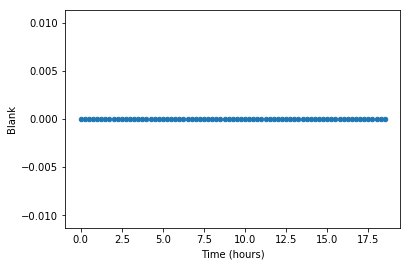

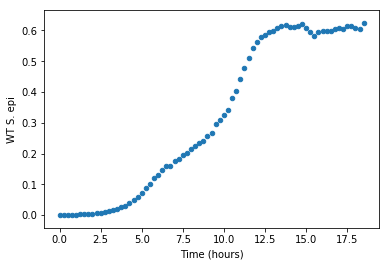

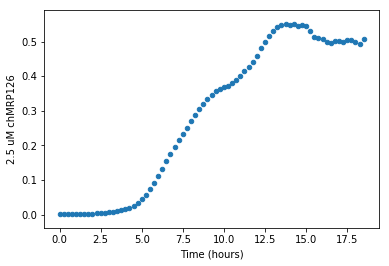

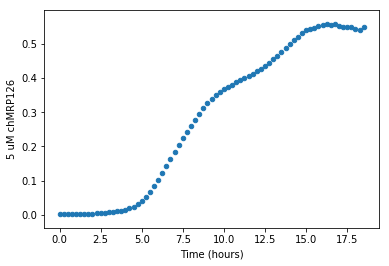

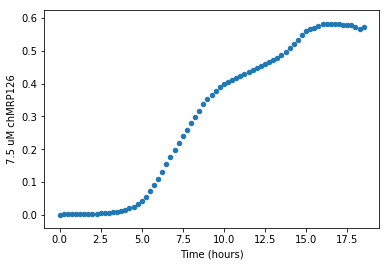

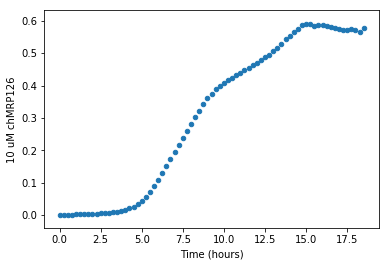

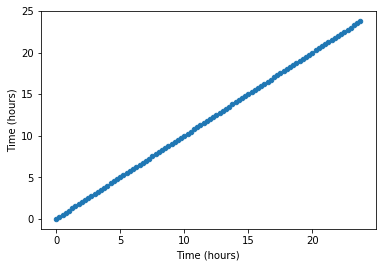

In [10]:
data_labels = ["Blank", "WT S. epi", "2.5 uM chMRP126", "5 uM chMRP126", "7.5 uM chMRP126", "10 uM chMRP126"]



ch_data2 = AMA_parser(file_name, 2, discard_chunk, discard_misc, blanks, data_labels, plot_title, averaging = True,
                 growth_curves = True, boxplots = False)

ch_data2